# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [5]:
w = data[data.race=='w']
b = data[data.race=='b']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

## Data Preparation

Before I get started, I want to clean up the data a little bit and remove all but the 'call' column since that's all we are concentrating on for this project and the data is already split into races which makes the 'race' column redundant.

In [7]:
# Remove all columns except 'call'
w = w.loc[:,'call'].values
b = b.loc[:,'call'].values

## 1) What test is appropriate for this problem? Does CLT apply?

In [8]:
# Count number of callbacks and non-callbacks for both datasets
print(len(w[w == 0]))
print(len(w[w == 1]))

print(len(b[b == 0]))
print(len(b[b == 1]))

2200
235
2278
157


The Central Limit Theorem applies to this problem since the number of "successes" and "failures" are over 10 for both data sets and each observation can be considered independent since it's less than 10% of the population.
For this problem, the z-test will be most applicable since we have a test about a proportion and not a difference in means.

## 2) What are the null and alternate hypotheses?

Here, we'll assume the null hypothesis that the probability of a callback is the same regardless of race.
- $H_0$: $p_b = p_w$
- $H_1$: $p_b \neq p_w$

In [9]:
# Your solution to Q3 here

## 3) Compute margin of error, confidence interval, and p-value. Try using bootstrapping and the frequentist statistical approaches.

Below we see that the average callback was about 9.65% for white-sounding names and 6.45% for black-sounding names but we don't know if that is significant or happened by chance. To perform bootstrapping, I want to permutate both data sets and compare the difference in means(callback proportion) with the observed difference in mean of 3.20% under the null hypothesis.

In [10]:
# Compute the callback rate for both w and b
w_c_rate = np.mean(w)
b_c_rate = np.mean(b)
obs_diff = w_c_rate - b_c_rate

print(w_c_rate)
print(b_c_rate)

0.09650924
0.064476386


In [11]:
# Create a function to draw bootstrap replicates of the mean
def perm_reps_mean(data1, data2, size=1):
    '''This function draws the bootstrap replicates of the mean for a given data set'''
    # Set the random seed
    np.random.seed(25)
    
    # Initialize an empty array
    reps = np.empty(size)

    # Concatenate arrays
    concat = np.concatenate((data1, data2))
    
    # Create for loop to create bootstrap replicates of the mean
    for i in range(size):
        permed = np.random.permutation(concat)
        new_data1 = permed[:len(data1)]
        new_data2 = permed[len(data1):]
        reps[i] = np.mean(new_data1) - np.mean(new_data2)
    
    return reps

In [12]:
# Create permutation replicates of w and b
diffs = perm_reps_mean(w, b, size=10000)

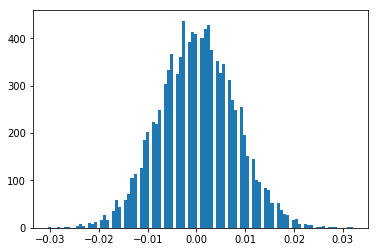

In [13]:
_ = plt.hist(diffs, bins = 100)

Now that I've resampled the data 10000 times and calculated the difference, I want to see how probable it is to get a value of `diff` or greater. I want a significance level of 5%, or 0.05, and anything less will be statistically significant.

In [14]:
# Calculate the p-value for getting a value greater than diff
p = np.sum(diffs >= obs_diff)/len(diffs)
print(p)

0


From my bootstraps test, I got a p-value of 0 which is less than our significance level meaning we can reject the null hypothesis and conclude that the there's a difference in callbacks between white-sounding names and black-sounding names.

The frequentist statistical approach can be done by manually calculating the standard error and comparing that to the observed difference to get our confidence interval and p-value at a 95% confidence level.

In [22]:
# Calculate and assign the probability proportions and total length of each data set
n_w = len(w)
n_b = len(b)
print('The probability proportion for w is %f with length %i' % (w_c_rate, n_w))
print('The probability proportion for b is %f with length %i' % (b_c_rate, n_b))

#  Calculate the observed difference in the proportions
print('The observed difference is %f' % obs_diff)

# Calculate the standard error
stand_err = np.sqrt((w_c_rate*(1-w_c_rate))/n_w + (b_c_rate*(1-b_c_rate))/n_b)

# Calculate the margin of error and confidence interval at 95% confidence level
margin_error = 1.96*stand_err
print('The margin of error for (w_c_rate - b_c_rate) with a 95%% confidence level is %f' % margin_error)

upper = (obs_diff + margin_error)*100
lower = (obs_diff - margin_error)*100
print('With 95%% confidence, the difference in proportions is between %f%% and %f%%' % (lower, upper))

# Calculate the p-value for obs_diff
z_score = obs_diff/stand_err
p_val = stats.norm.sf(np.abs(z_score))*2
print('The p-vale for obs_diff is %f' % p_val)

The probability proportion for w is 0.096509 with length 2435
The probability proportion for b is 0.064476 with length 2435
The observed difference is 0.032033
The margin of error for (w_c_rate - b_c_rate) with a 95% confidence level is 0.015255
With 95% confidence, the difference in proportions is between 1.677745% and 4.728826%
The p-vale for obs_diff is 0.000039


According to the data, we got a difference in probability proportions of about 0.032 or $3.2\%$. With the frequentist method, and a 95% confidence level, I got a margin of error of 0.015 resulting in a confidence interval from $(0.017, 0.047)$, or $(1.7\%, 4.7\%)$. This means that I have 95% confidence that the difference in probability proportions is from 1.7% to 4.7% in favor of white-sounding names. This is backed up by the fact that the p-value is smaller than our alpha, 0.05, meaning that the observed difference in the data is statistically significant. Therefore we can reject the null hypothesis and conclude that the callback rates between white-sounding and black-sounding names is different.

## 4) Write a story describing the statistical significance in the context or the original problem.

Racial discrimination continues to be a big political issue that exists in almost all aspects of society. Although the problems have become less public and demonstrative, that doesn't discard the fact that it still exists. The objective of this project was to investigate your ability to get called back for job interviews based solely on how your name sounds. 

From the data, we saw that there was a difference of about 3% in favor of white-sounding names getting more callbacks. By the two difference statistical approaches, bootstrap and frequentist, we saw that the difference is statistically significant; concluding that, with 95% confidence, the difference in callback rates in favor of white-sounding names ranges from 1.7% to 4.7%.

## 5) Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

This project does not mean that your race or how your name sounds is the most important factor in callback rates. Other factors like age, eligibility, and background weren't accounted for in this project which can also affect callback rates. For future analysis, we can perform a logistic regression to see which other factors affect callback rates the most and how those factors differ, if they differ, between race.